In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, GlobalAveragePooling1D, Concatenate, Softmax, MultiHeadAttention, GlobalMaxPooling1D, LayerNormalization

In [2]:
df = pd.read_csv('/kaggle/input/hate-speech/Hate speech excel file (1).csv', encoding='latin-1')

In [3]:
df.dropna(subset='sentiment', inplace=True)

In [4]:
df['sentiment'] = df['sentiment'].apply(lambda x : 1 if x==1.0 else 0)

In [5]:
def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@[\w]+', '', text)
    text = re.sub(r'RT\s@[\w]+:', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

In [6]:
df['cleaned_caption'] = df['caption_segment'].apply(clean_tweet)

In [7]:
tweets = df['cleaned_caption']
labels = df['sentiment']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index

In [9]:
embeddings_index = {}
glove_file_path = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt' 

In [10]:
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [11]:
embedding_dim = 100  
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
max_length = 115
x = pad_sequences(sequences, maxlen=max_length)
y = labels.values 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
vocab_size = len(word_index) +1

In [15]:
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (10702, 100)


In [16]:
def create_model(vocab_size, embedding_dim, embedding_matrix):
    inputs = Input(shape=(None,), name='input_layer')
    
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    )(inputs)
    
    conv_1x1 = Conv1D(filters=64, kernel_size=1, activation='relu', 
                      kernel_regularizer=regularizers.l2(0.001))(embedding)
    conv_3x3 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', 
                      kernel_regularizer=regularizers.l2(0.001))(embedding)
    conv_5x5 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', 
                      kernel_regularizer=regularizers.l2(0.001))(embedding)
    conv_7x7 = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same', 
                      kernel_regularizer=regularizers.l2(0.001))(embedding)

    combined_word_features = Concatenate()([conv_1x1, conv_3x3, conv_5x5, conv_7x7])
    max_pooled_word = MaxPooling1D(pool_size=2)(combined_word_features)

    word_bi_lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))(max_pooled_word)

    # word_attention = MultiHeadAttention(num_heads=8, key_dim=64, kernel_regularizer=regularizers.l2(0.001))(word_bi_lstm, word_bi_lstm, word_bi_lstm)
    context = word_bi_lstm

    word_vector = GlobalMaxPooling1D()(context)

    conv_1x1_sent = Conv1D(filters=64, kernel_size=1, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.001))(context)
    conv_3x3_sent = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(0.001))(context)
    conv_5x5_sent = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(0.001))(context)
    conv_7x7_sent = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(0.001))(context)

    combined_sentence_features = Concatenate()([conv_1x1_sent, conv_3x3_sent, conv_5x5_sent, conv_7x7_sent])
    max_pooled_sentence = MaxPooling1D(pool_size=2)(combined_sentence_features)

    sentence_bi_lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))(max_pooled_sentence)

    sentence_attention = MultiHeadAttention(num_heads=8, key_dim=64, kernel_regularizer=regularizers.l2(0.001))(sentence_bi_lstm, sentence_bi_lstm, sentence_bi_lstm)
    document_vector = sentence_attention

    doc_vector = GlobalAveragePooling1D()(document_vector)

    outputs = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(doc_vector)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [17]:
model = create_model(vocab_size=vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 100) │  1,070,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │      6,464 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 64)  │     19,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 64)  │     32,064 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 64)  │     44,864 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 256) │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, None, 256) │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │    164,352 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 64)  │     24,640 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 64)  │     41,024 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, None, 64)  │     57,408 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 256) │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, None, 256) │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, None, 128) │    164,352 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │    263,808 │ bidirectional_1[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multi_head_atten

 Total params: 1,896,825 (7.24 MB)

 Trainable params: 1,896,825 (7.24 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(curve="ROC", summation_method="interpolation", name='auc')
]

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True  
)

In [20]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=METRICS)

In [21]:
history = model.fit(
    x_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(x_test, y_test),
    callbacks = [early_stopping]
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.6375 - auc: 0.6662 - loss: 2.1490 - precision: 0.5715 - recall: 0.3592 - val_accuracy: 0.7475 - val_auc: 0.8189 - val_loss: 1.5030 - val_precision: 0.6484 - val_recall: 0.7345
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7259 - auc: 0.7745 - loss: 1.4391 - precision: 0.6941 - recall: 0.6442 - val_accuracy: 0.7980 - val_auc: 0.8653 - val_loss: 1.0967 - val_precision: 0.8533 - val_recall: 0.5664
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8067 - auc: 0.8723 - loss: 1.0280 - precision: 0.8254 - recall: 0.6765 - val_accuracy: 0.7576 - val_auc: 0.8625 - val_loss: 0.9948 - val_precision: 0.9020 - val_recall: 0.4071
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8345 - auc: 0.8990 - loss: 0.8480 - precision: 0.8505 - recall: 0.7381 - val_accuracy: 0.8047 - val_auc: 0.8845 - val_loss: 0.8087 - val_precision: 0.7778 - val_recall: 0.6814
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━

In [22]:
results = model.evaluate(x_test, y_test)

print('Results using only sentence-level attention:')
print(f'Loss: {results[0]}')
print(f'Accuracy: {results[1]}')
print(f'Precision: {results[2]}')
print(f'Recall: {results[3]}')
print(f'AUC: {results[4]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7734 - auc: 0.8868 - loss: 0.8504 - precision: 0.6280 - recall: 0.8180
Results using only sentence-level attention:
Loss: 0.7854257225990295
Accuracy: 0.7979797720909119
Precision: 0.6992481350898743
Recall: 0.8230088353157043
AUC: 0.8934687376022339


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


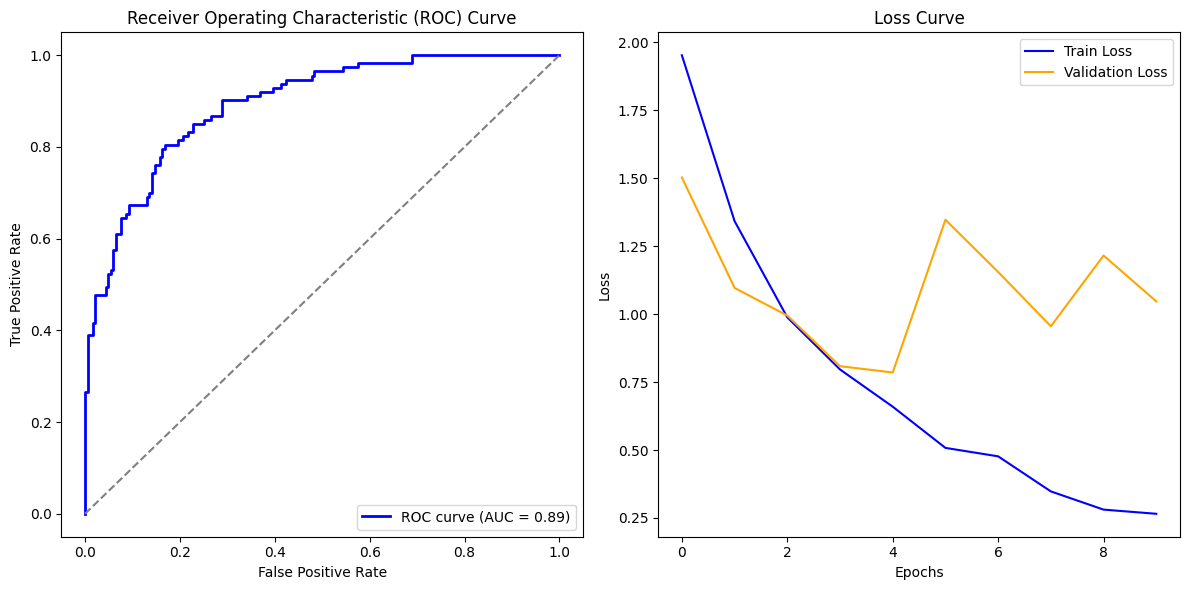

Your image has been saved to: roc_loss_curve.png


In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot ROC Curve
y_pred_prob = model.predict(x_test).ravel() 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

file_path = 'roc_loss_curve.png'
plt.tight_layout()
plt.savefig(file_path)

plt.show()

print(f"Your image has been saved to: {file_path}")